In [30]:
import numpy as np
import pandas as pd
from interpolation import interp
from numba import njit, prange
from scipy.stats import lognorm
import matplotlib.pyplot as plt

In [ ]:
# Exchange rate
# https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries

# GPD_PPP_2017
# https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.MKTP.PP.KD&country=BRA,USA

# Household Consumption (Constant 2017 US$)
# https://databank.worldbank.org/reports.aspx?source=2&series=NE.CON.PRVT.PP.KD&country=BRA,USA#

# SPY (S&P 500)
# https://finance.yahoo.com/quote/SPY/history

# BOV (IBovespa)
# https://finance.yahoo.com/quote/BOVA11.SA/history

#### GDP, PPP em dólares constantes de 2017

In [31]:
real_gdp = pd.read_excel('data\GDP_Constant_PPP_2017.xlsx')
real_gdp = real_gdp.drop([0,1,2,3]).reset_index().drop(columns=['index'])
real_gdp = real_gdp.drop([0,1,2,3,4,5,28])
var_log_gdp = np.log(real_gdp[['United States', 'Brazil']]).pct_change().apply(lambda x: x*100).fillna(0)

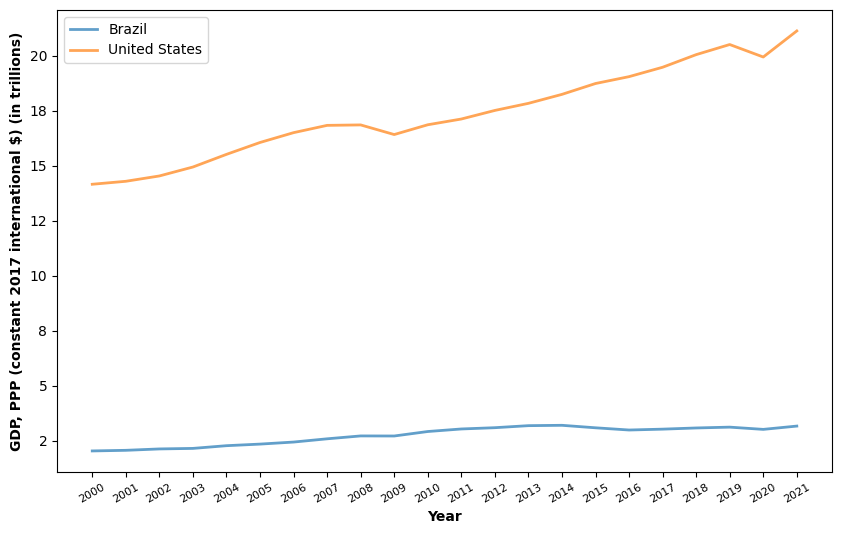

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

for country in ('Brazil', 'United States'):
    ax.plot(real_gdp['Year'], real_gdp[country], lw=2, alpha=0.7, label=country)

ax.legend(loc='upper left')
ax.set_xticks(real_gdp['Year'])
plt.ylabel(ylabel='GDP, PPP (constant 2017 international $) (in trillions)', fontweight='bold', fontsize = 10)
plt.xlabel(xlabel='Year', fontweight='bold', fontsize = 10)
plt.xticks(fontsize = 8, rotation=30)
plt.gcf().axes[0].yaxis.set_major_formatter(lambda x, pos: f'{x / 1e12:.0f}')
plt.show()

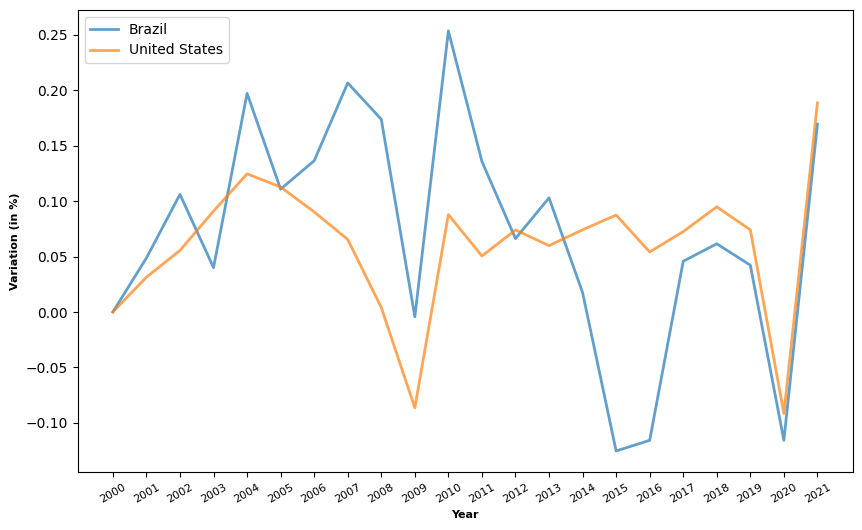

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

for country in ('Brazil', 'United States'):
    ax.plot(real_gdp['Year'], var_log_gdp[country], lw=2, alpha=0.7, label=country)

ax.legend(loc='upper left')
ax.set_xticks(real_gdp['Year'])
plt.xlabel('Year', fontweight='bold', fontsize = 8)
plt.ylabel('Variation (in %)', fontweight='bold', fontsize = 8)
plt.xticks(fontsize = 8, rotation=30)
plt.show()

In [35]:
var_log_gdp.describe()

,United States,Brazil
count,22.000000,22.000000
mean,0.059762,0.070599
std,0.062116,0.103565
min,-0.091571,-0.125387
25%,0.051402,0.023089
50%,0.073257,0.063870
75%,0.089660,0.136270
max,0.188592,0.253549


In [36]:
sigma_usa = var_log_gdp.describe().loc['std', 'United States']
sigma_brazil = var_log_gdp.describe().loc['std', 'Brazil']

#### Consumo em Preços constantes, PPC

In [38]:
consumption = pd.read_csv('data\Household_Consumption_PPP_2017.csv')
consumption = consumption.drop([2,3,4,5,6])
consumption = consumption.drop(columns=['Series Name', 'Series Code', 'Country Code'])
consumption = consumption.set_index('Country Name')
consumption = consumption.T
consumption.index = range(2000, 2023)
consumption = consumption.drop([2022])
consumption[['Brazil', 'United States']] = consumption[['Brazil', 'United States']].astype('float')

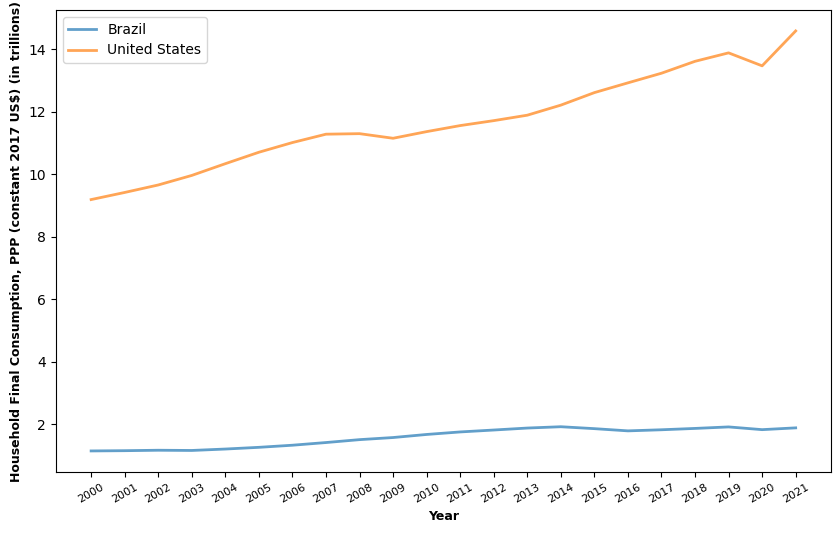

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

for country in ('Brazil', 'United States'):
    ax.plot(consumption.index, consumption[country], lw=2, alpha=0.7, label=country)

ax.legend(loc='upper left')
ax.set_xticks(consumption.index)
plt.ylabel(ylabel='Household Final Consumption, PPP (constant 2017 US$) (in trillions)', fontweight='bold', fontsize = 9)
plt.xlabel(xlabel='Year', fontweight='bold', fontsize = 9)
plt.xticks(fontsize = 8, rotation=30)
plt.gcf().axes[0].yaxis.set_major_formatter(lambda x, pos: f'{x / 1e12:.0f}')
plt.show()

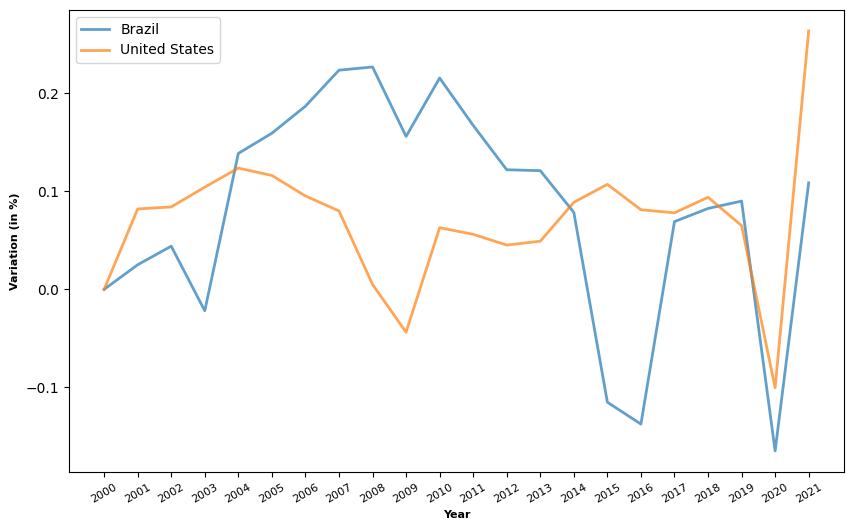

In [40]:
var_log_consumption = np.log(consumption[['Brazil', 'United States']]).pct_change().apply(lambda x: x*100).fillna(0)

fig, ax = plt.subplots(figsize=(10, 6))

for country in ('Brazil', 'United States'):
    ax.plot(consumption.index, var_log_consumption[country], lw=2, alpha=0.7, label=country)

ax.legend(loc='upper left')
ax.set_xticks(consumption.index)
plt.xlabel('Year', fontweight='bold', fontsize = 8)
plt.ylabel('Variation (in %)', fontweight='bold', fontsize = 8)
plt.xticks(fontsize = 8, rotation=30)
plt.show()

In [41]:
var_log_consumption.describe()

Country Name,Brazil,United States
count,22.000000,22.000000
mean,0.080678,0.069852
std,0.112500,0.068859
min,-0.164782,-0.100323
25%,0.029803,0.050836
50%,0.099295,0.080566
75%,0.158394,0.094875
max,0.226774,0.263505


#### Taxa de Câmbio

In [ ]:
er = pd.read_csv('data\Exchange_rate.csv', sep=',')
er = er.drop(columns=['Unnamed: 2'])
er.columns = ['Date', 'Exchange_Rate']
er = er.fillna(method='ffill')
er = er[(er['Date'].str.contains('/20')) & (er['Date'].str.contains('01/12'))]
# er = er.iloc[:-1].reset_index().drop(columns=['index'])

### Séries de preços (Bovespa e S&P 500)

In [44]:
bovespa = pd.read_csv('data\BOVA11.SA.csv')[['Date','Adj Close']]
bovespa = bovespa[(bovespa['Date'].str.endswith('12-01')) & (bovespa['Date'].str.contains('20'))].reset_index().drop(columns='index')
bovespa['Date'] = bovespa['Date'].str.replace('-12-01', '')

sp500 = pd.read_csv('data\SPY.csv')[['Date', 'Adj Close']]
sp500 = sp500[(sp500['Date'].str.endswith('12-01')) & (sp500['Date'].str.contains('20'))].reset_index().drop(columns='index')
sp500['Date'] = sp500['Date'].str.replace('-12-01', '')

In [45]:
# # Ajustando a partir da inflação e taxa de câmbio
bovespa['Price_USD'] = bovespa['Adj Close']/list(er.iloc[9:, 1])

prices_series = pd.DataFrame()
prices_series['Year'] = bovespa['Date']
prices_series['Brazil'] = bovespa['Price_USD']
prices_series['United States'] = sp500['Adj Close']

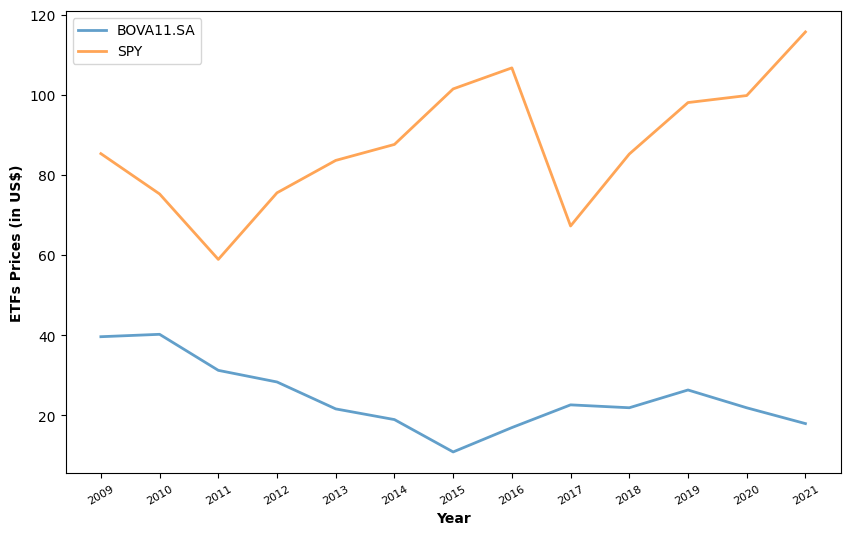

In [193]:
fig, ax = plt.subplots(figsize=(10, 6))

for country in ('Brazil', 'United States'):
    ax.plot(prices_series['Year'].iloc[:-2], prices_series[country].iloc[:-2], lw=2, alpha=0.7, label=country)

ax.legend(loc='upper left', labels=['BOVA11.SA', 'SPY'])
ax.set_xticks(prices_series['Year'].iloc[:-2])
plt.ylabel(ylabel='ETFs Prices (in US$)', fontweight='bold', fontsize = 10)
plt.xlabel(xlabel='Year', fontweight='bold', fontsize = 10)
plt.xticks(fontsize = 8, rotation=30)
plt.show()

#### Variação Consumo e Preços

In [194]:
var_log_prices_consumption = pd.DataFrame()
var_log_prices_consumption['Year'] = bovespa.iloc[:-2,0]
var_log_prices_consumption['Brazil_Prices'] = np.log(bovespa.iloc[:-2, 2]).pct_change().apply(lambda x: x*100).fillna(0)
var_log_prices_consumption['Brazil_Consumption'] = list(np.log(consumption['Brazil'].iloc[9:]).pct_change().apply(lambda x: x*100).fillna(0))

var_log_prices_consumption['USA_Prices'] = np.log(sp500.iloc[:-2, 1]).pct_change().apply(lambda x: x*100).fillna(0)
var_log_prices_consumption['USA_Consumption'] = list(np.log(consumption['United States'].iloc[9:]).pct_change().apply(lambda x: x*100).fillna(0))

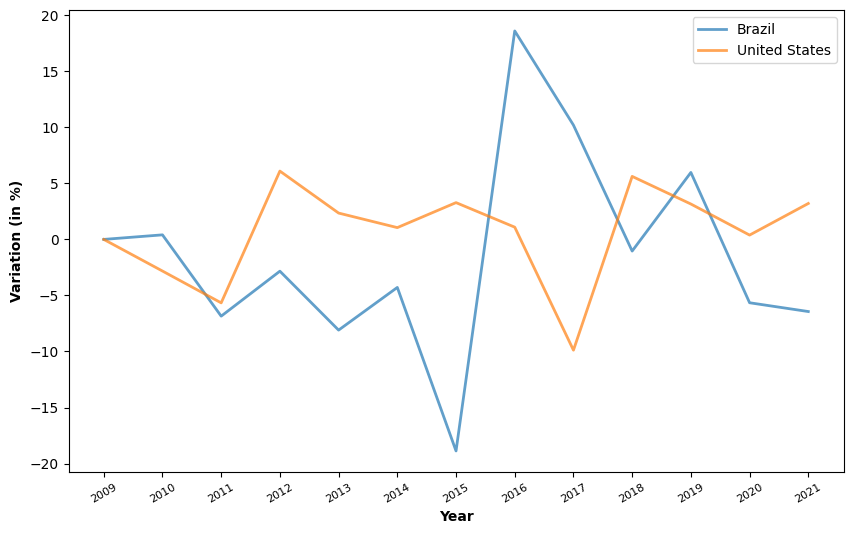

In [195]:
fig, ax = plt.subplots(figsize=(10, 6))

for variation in ('Brazil_Prices', 'USA_Prices'):
    ax.plot(var_log_prices_consumption['Year'], var_log_prices_consumption[variation], lw=2, alpha=0.7, label=variation)

ax.legend(loc='upper right', labels=['Brazil', 'United States'])
ax.set_xticks(var_log_prices_consumption['Year'])
plt.ylabel(ylabel='Variation (in %)', fontweight='bold', fontsize = 10)
plt.xlabel(xlabel='Year', fontweight='bold', fontsize = 10)
plt.xticks(fontsize = 8, rotation=30)
plt.show()

In [198]:
var_log_prices_consumption[['Brazil_Prices', 'USA_Prices']].describe()

,Brazil_Prices,USA_Prices
count,13.000000,13.000000
mean,-1.452525,0.605979
std,9.254477,4.478511
min,-18.872892,-9.883538
25%,-6.435832,0.000000
50%,-2.834661,1.091943
75%,0.406247,3.206214
max,18.599741,6.095460


#### Variação Brasil

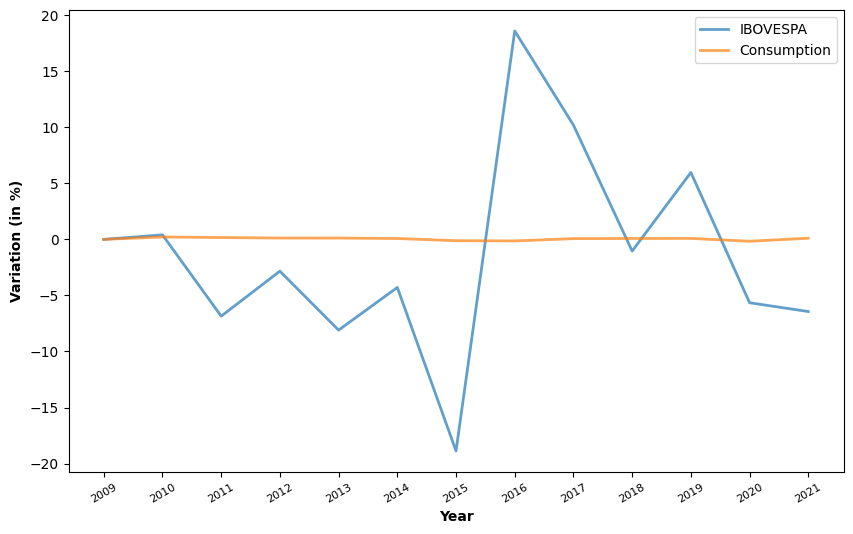

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))

for variation in ('Brazil_Prices', 'Brazil_Consumption'):
    ax.plot(prices_series.iloc[:-2, 0], var_log_prices_consumption[variation], lw=2, alpha=0.7, label=variation)

ax.legend(loc='upper right', labels=['IBOVESPA', 'Consumption'])
ax.set_xticks(prices_series.iloc[:-2, 0])
plt.ylabel(ylabel='Variation (in %)', fontweight='bold', fontsize = 10)
plt.xlabel(xlabel='Year', fontweight='bold', fontsize = 10)
plt.xticks(fontsize = 8, rotation=30)
plt.show()

#### Variação EUA

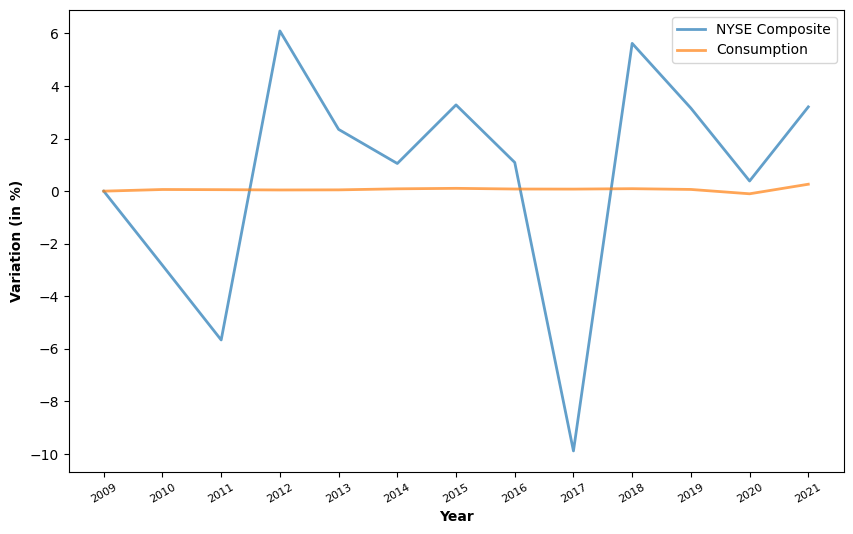

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))

for variation in ('USA_Prices', 'USA_Consumption'):
    ax.plot(prices_series.iloc[:-2, 0], var_log_prices_consumption[variation], lw=2, alpha=0.7, label=variation)

ax.legend(loc='upper right', labels=['NYSE Composite', 'Consumption'])
ax.set_xticks(prices_series.iloc[:-2, 0])
plt.ylabel(ylabel='Variation (in %)', fontweight='bold', fontsize = 10)
plt.xlabel(xlabel='Year', fontweight='bold', fontsize = 10)
plt.xticks(fontsize = 8, rotation=30)
plt.show()

### Modelo de Lucas

In [113]:
class LucasTree:
    """
    Class to store parameters of the Lucas tree model.

    """

    def __init__(self,
                 γ=2,            # CRRA utility parameter
                 β=0.95,         # Discount factor
                 α=0.90,         # Correlation coefficient
                 σ=0.1,          # Volatility coefficient
                 grid_size=100):

        self.γ, self.β, self.α, self.σ = γ, β, α, σ

        # Set the grid interval to contain most of the mass of the
        # stationary distribution of the consumption endowment
        ssd = self.σ / np.sqrt(1 - self.α**2)
        grid_min, grid_max = np.exp(-4 * ssd), np.exp(4 * ssd)
        self.grid = np.linspace(grid_min, grid_max, grid_size)
        self.grid_size = grid_size

        # Set up distribution for shocks
        self.ϕ = lognorm(σ)
        self.draws = self.ϕ.rvs(500)

        self.h = np.empty(self.grid_size)
        for i, y in enumerate(self.grid):
            self.h[i] = β * np.mean((y**α * self.draws)**(1 - γ))


def operator_factory(tree, parallel_flag=True):

    """
    Returns approximate Lucas operator, which computes and returns the
    updated function Tf on the grid points.

    tree is an instance of the LucasTree class

    """

    grid, h = tree.grid, tree.h
    α, β = tree.α, tree.β
    z_vec = tree.draws

    @njit(parallel=parallel_flag)
    def T(f):
        """
        The Lucas operator
        """

        # Turn f into a function
        Af = lambda x: interp(grid, f, x)

        Tf = np.empty_like(f)
        # Apply the T operator to f using Monte Carlo integration
        for i in prange(len(grid)):
            y = grid[i]
            Tf[i] = h[i] + β * np.mean(Af(y**α * z_vec))

        return Tf

    return T



def solve_model(tree, tol=1e-6, max_iter=500):
    """
    Compute the equilibrium price function associated with Lucas
    tree

    * tree is an instance of LucasTree

    """
    # Simplify notation
    grid, grid_size = tree.grid, tree.grid_size
    γ = tree.γ

    T = operator_factory(tree)

    i = 0
    f = np.ones_like(grid)  # Initial guess of f
    error = tol + 1
    while error > tol and i < max_iter:
        Tf = T(f)
        error = np.max(np.abs(Tf - f))
        f = Tf
        i += 1

    price = f * grid**γ  # Back out price vector

    return price

In [188]:
countries_dict = {"Brazil": {"Beta": 0.89, "Gamma": 4.89, 'Alpha': 0,'Sigma': sigma_brazil},
                  "United States": {"Beta": 0.995, "Gamma": 2.25, 'Alpha': -0.551103, 'Sigma': sigma_usa}}

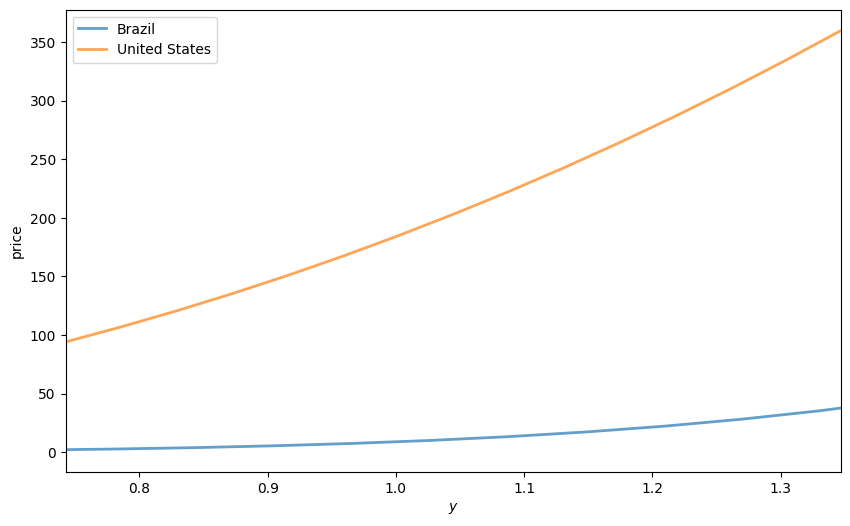

In [205]:
fig, ax = plt.subplots(figsize=(10, 6))

prices_list = []

for country in countries_dict:
    β = countries_dict[country]['Beta']
    γ = countries_dict[country]['Gamma']
    α = countries_dict[country]['Alpha']
    σ = countries_dict[country]['Sigma']
    tree = LucasTree(β=β, γ=γ, α=α, σ=σ, grid_size=15)
    grid = tree.grid
    price_vals = solve_model(tree)
    prices_list.append(price_vals)
    label = f'{country}'
    ax.plot(grid, price_vals, lw=2, alpha=0.7, label=label)

ax.legend(loc='upper left')
ax.set(xlabel='$y$', ylabel='price', xlim=(min(grid), max(grid)))
plt.show()